# Imports
pyabf reads your abf files, scipy contains your peak-finding functions, matplotlib makes pretty graphs, and pandas and numpy are essential packages

In [242]:
import efel
import pyabf.plot
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,scale, normalize
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import distance
from scipy.cluster import hierarchy
from matplotlib.ticker import ScalarFormatter, MaxNLocator

# Load your data
For data containing multiple sweeps, sweep 0 is automatically loaded unless otherwise specified. Printing your abf will show you the file information (channels, sampling rate, number of sweeps, length of sweep window, protocol used)

In [10]:
folder = r"C:\Users\Valerie\Documents\Tejeda_Lab\4_ephys_data\MOR-tdT spiking file"

In [241]:
def cc_loop(folder):
    for i in os.listdir(folder):
        if i.endswith('.abf'):
            print(i)
            data = (folder + '/' + i)
            abf = pyabf.ABF(data)
            sweep = abf.setSweep(sweepNumber=23, channel=0)
            time = abf.sweepX*1000 # in miliseconds
            voltage = abf.sweepY
            current = abf.sweepC
            trace = {'T': abf.sweepX*1000, 
                 'V': abf.sweepY,
                 'stim_start': [2609.35],
                 'stim_end': [3609.3]} 
            traces = [trace]
            currents = [] 
            t1 = int(2609.35*abf.dataPointsPerMs) 
            t2 = int(3609.30*abf.dataPointsPerMs)
            current_mean = np.average(abf.sweepC[t1:t2]) 
            a = list(efel.getFeatureNames())
            table = pd.DataFrame(columns=[a])
            for sweep in abf.sweepList: # e.g. abf.sweepList[1:3] to select the range
                abf.setSweep(sweep)
                # Defines a trace
                trace = {'T': abf.sweepX*1000, 
                         'V': abf.sweepY,
                         'stim_start': [2609.35],
                         'stim_end': [3609.3]} 
                traces = [trace]

                # Define the parameters for detection
                efel.api.setThreshold(0) # Voltage threshold for detection
                efel.api.setDerivativeThreshold(0) # dV/dt threshold for detection

                # Define the output results
                feature_values = efel.getFeatureValues(traces,
                                                       a,
                                                       raise_warnings=None)[0]
                def replace_none_with_empty_str(some_dict):
                    return { k: ('' if v is None else v) for k, v in some_dict.items() }
                feature_values = replace_none_with_empty_str(feature_values)

                # Optional: add a column with the current steps
                current = abf.sweepC
                currents = [] # Current value between t1 and t2 (ms) for each step
                t1 = int(2609.35*abf.dataPointsPerMs) 
                t2 = int(3609.30*abf.dataPointsPerMs)
                current_mean = np.average(abf.sweepC[t1:t2])
                currents.append(current_mean)


                # Create table from the results
                # Use [0] to extract the values from the Spikecount array
                length = len(table)
                table.loc[length, 'Current_step'] = current_mean
                for z in a:
                    if (len(feature_values[z]) == 0):
                        continue
                    else:
                        table.loc[length, z] = feature_values[z][0]
                table.loc[length, 'Spikecount'] = feature_values['Spikecount'][0] 
                # Some features requires AP > 0 or more
                if feature_values['Spikecount'] is not None: 
                    table.loc[length, 'Latency_ms'] = feature_values['time_to_first_spike']
                    if feature_values['Spikecount'] > 4:  
                        table.loc[length, 'adaptation'] = feature_values['adaptation_index'][0]
                        table.loc[length, 'ISI_CV'] = feature_values['ISI_CV'][0] 
                        table.loc[length, 'ISI_mean'] = feature_values['ISI_values'][0]/1000

                table.to_csv(folder + '/' + i + '.csv')

# PCA

In [191]:
import sklearn.preprocessing
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,scale, normalize
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
from mpl_toolkits.mplot3d import Axes3D
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.stats import pearsonr
from matplotlib.ticker import ScalarFormatter, MaxNLocator

### 0 is nonresponsive, 1 is MOR, 2 is DOR, 3 is both

In [196]:
folder = r"C:\Users\Valerie\Documents\Tejeda_Lab\4_ephys_data\MOR-tdT spiking file"
df = pd.read_csv(r"C:\Users\Valerie\Downloads\spike_features.csv")

In [186]:
for i in os.listdir(folder):
    if i.endswith('.csv'):
        print(i)
        data = pd.read_csv(folder + '/' + i)
        if 'depol_block' in data.columns:
            data.drop(columns=['depol_block', 'Current_step'], inplace=True)
        data.iloc[0] = data.mean()
        data.iloc[0,182] = np.where(data['depol_block_bool'] == 1)[0][0]
        df.loc[len(df)] = data.iloc[0]
        df.iloc[len(df)-1, 187] = i
df.to_csv(r"C:\Users\Valerie\Downloads\spike_features.csv")

2022_12_12_0000.abf.csv
2022_12_12_0002.abf.csv
2022_12_12_0004.abf.csv
2022_12_13_0002.abf.csv
2022_12_13_0005.abf.csv
2022_12_14_0000.abf.csv
2022_12_14_0005.abf.csv
2022_12_14_0008.abf.csv


In [223]:
df = pd.read_csv(r"C:\Users\Valerie\Downloads\spike_features.csv")

In [200]:
df

,Unnamed: 0,ADP_peak_amplitude,ADP_peak_indices,ADP_peak_values,AHP1_depth_from_peak,AHP2_depth_from_peak,AHP_depth,AHP_depth_abs,AHP_depth_abs_slow,AHP_depth_diff,...,initburst_sahp,initburst_sahp_vb,initburst_sahp_ssse,depol_block_bool,spikes_per_burst,Latency_ms,adaptation,ISI_mean,Cell_Type,Cell
0,0,0.000000,26321.66667,-50.130208,79.825846,75.246175,13.318616,-50.130208,-43.410238,1.981608,...,-33.582899,30.159189,-17.164079,11,20.533333,20.563333,0.017313,0.024333,1,2022_08_24_0000
1,1,3.425598,27312.62500,-55.797577,84.453583,80.392020,7.533686,-59.223175,-42.898996,2.066476,...,-42.495728,24.017711,-7.378250,18,59.857143,7.537500,0.005444,0.011650,2,2022_08_25_0000
2,2,3.206693,28118.53846,-40.055495,87.827242,71.139865,25.220387,-43.262188,-38.589478,3.841824,...,NaN,NaN,NaN,13,2.000000,20.234615,NaN,NaN,0,2022_08_26_0001
3,3,1.715766,28499.44444,-40.449354,86.683485,85.449219,25.142775,-42.165120,-41.591099,3.121512,...,NaN,NaN,NaN,17,5.857143,41.505556,0.022250,0.142617,0,2022_08_26_0003
4,4,0.008138,26262.00000,-40.956624,87.713623,76.110840,18.037249,-40.964762,-36.564128,4.473877,...,-31.899192,25.770576,-14.754816,11,6.600000,14.576667,0.136666,0.033736,0,2022_08_26_0005
5,5,0.281839,28987.35294,-47.237621,83.657657,75.790405,13.373457,-47.519459,-35.847982,3.938675,...,-28.256734,33.310662,-7.949387,11,6.000000,287.561765,0.074034,0.015500,3,2022_10_18_0000
6,6,0.000000,24731.86667,-61.429850,89.593506,82.653809,-4.815339,-61.429850,-48.508708,2.085368,...,-43.984985,12.644752,-9.205179,17,54.200000,-137.563333,0.004102,0.115479,3,2022_10_26_0005
7,7,3.452846,28385.42857,-54.094587,69.505964,75.144450,22.600228,-57.547433,-50.425212,-1.775106,...,-48.339844,31.880708,-7.436910,17,49.333333,183.107143,0.003251,0.016733,2,2022_11_30_0000
8,8,6.042480,27357.75000,-40.725708,89.973450,NaN,25.780607,-46.768188,NaN,NaN,...,NaN,NaN,NaN,22,NaN,30.825000,NaN,NaN,0,2022_11_30_0003
9,9,0.007629,26430.62500,-45.402527,64.315796,58.223724,28.115578,-45.410156,-35.821533,4.875183,...,-38.787842,34.847339,-13.812225,18,3.000000,31.662500,0.355669,0.010650,0,2022_11_30_0006


In [224]:
#df.dropna(axis=1, inplace=True)
df.fillna(0, inplace=True)
df.replace('#DIV/0!', 0, inplace=True)
df1 = df.drop(columns=[df.columns[0],'Cell_Type','Cell', 'is_not_stuck', 'time', 'trace_check', 'time.1', 'current.1'])

In [225]:
df1

,ADP_peak_amplitude,ADP_peak_indices,ADP_peak_values,AHP1_depth_from_peak,AHP2_depth_from_peak,AHP_depth,AHP_depth_abs,AHP_depth_abs_slow,AHP_depth_diff,AHP_depth_from_peak,...,voltage.1,ISIs,initburst_sahp,initburst_sahp_vb,initburst_sahp_ssse,depol_block_bool,spikes_per_burst,Latency_ms,adaptation,ISI_mean
0,0.000000,26321.66667,-50.130208,79.825846,75.246175,13.318616,-50.130208,-43.410238,1.981608,79.825846,...,-62.974287,22.520000,-33.582899,30.159189,-17.164079,11,20.533333,20.563333,0.017313,0.024333
1,3.425598,27312.62500,-55.797577,84.453583,80.392020,7.533686,-59.223175,-42.898996,2.066476,84.453583,...,-65.158840,18.114286,-42.495728,24.017711,-7.378250,18,59.857143,7.537500,0.005444,0.011650
2,3.206693,28118.53846,-40.055495,87.827242,71.139865,25.220387,-43.262188,-38.589478,3.841824,87.827242,...,-67.618025,60.400000,0.000000,0.000000,0.000000,13,2.000000,20.234615,0.000000,0.000000
3,1.715766,28499.44444,-40.449354,86.683485,85.449219,25.142775,-42.165120,-41.591099,3.121512,86.683485,...,-67.699435,76.985714,0.000000,0.000000,0.000000,17,5.857143,41.505556,0.022250,0.142617
4,0.008138,26262.00000,-40.956624,87.713623,76.110840,18.037249,-40.964762,-36.564128,4.473877,87.713623,...,-60.184489,22.973333,-31.899192,25.770576,-14.754816,11,6.600000,14.576667,0.136666,0.033736
5,0.281839,28987.35294,-47.237621,83.657657,75.790405,13.373457,-47.519459,-35.847982,3.938675,83.657657,...,-59.953056,16.756250,-28.256734,33.310662,-7.949387,11,6.000000,287.561765,0.074034,0.015500
6,0.000000,24731.86667,-61.429850,89.593506,82.653809,-4.815339,-61.429850,-48.508708,2.085368,89.593506,...,-56.382495,54.693333,-43.984985,12.644752,-9.205179,17,54.200000,-137.563333,0.004102,0.115479
7,3.452846,28385.42857,-54.094587,69.505964,75.144450,22.600228,-57.547433,-50.425212,-1.775106,69.505964,...,-79.720811,17.650000,-48.339844,31.880708,-7.436910,17,49.333333,183.107143,0.003251,0.016733
8,6.042480,27357.75000,-40.725708,89.973450,0.000000,25.780607,-46.768188,0.000000,0.000000,89.973450,...,-71.994779,0.000000,0.000000,0.000000,0.000000,22,0.000000,30.825000,0.000000,0.000000
9,0.007629,26430.62500,-45.402527,64.315796,58.223724,28.115578,-45.410156,-35.821533,4.875183,64.315796,...,-74.556991,142.362500,-38.787842,34.847339,-13.812225,18,3.000000,31.662500,0.355669,0.010650


In [232]:
scaling = StandardScaler()
df1 = normalize(df1)
scaling.fit(df1)
X_Scaled = scaling.transform(df1)

pca = PCA(n_components=30)
principalComponents = pca.fit_transform(X_Scaled)

Text(0, 0.5, 'Explained Variance')

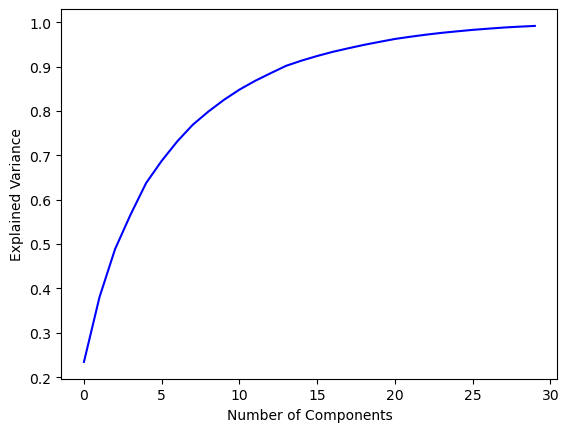

In [233]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')

In [169]:
df.Cell_Type.value_counts()

3    19
0    10
2     8
1     7
Name: Cell_Type, dtype: int64

Text(0, 0.5, 'PC2')

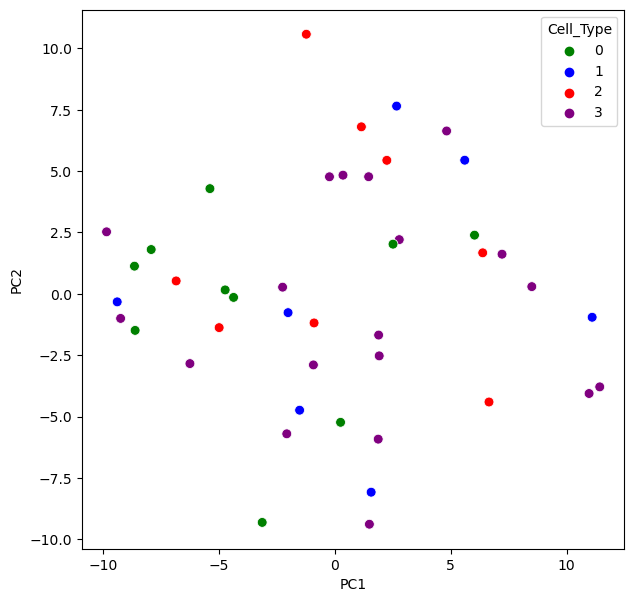

In [228]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X_Scaled)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])

plt.figure(figsize=(7,7))
sns.scatterplot(x = principalDf['principal component 1'], y= principalDf['principal component 2'], s=50, hue=df.Cell_Type, palette=['green', 'blue', 'red', 'purple'])
plt.xlabel('PC1')
plt.ylabel('PC2')

In [234]:
principalDf['Cell'] = df['Cell']
pca = principalDf.set_index('Cell')

In [235]:
pca = pca.transpose()

In [236]:
correlations = pca
correlations_array = np.asarray(pca)

row_linkage = hierarchy.linkage(
    distance.pdist(correlations_array), method='ward')

col_linkage = hierarchy.linkage(
    distance.pdist(correlations_array.T), method='ward')

In [237]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('Sample Index')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

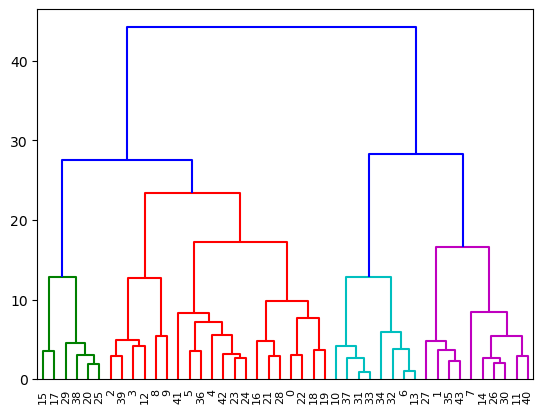

In [238]:
ind = pca.columns.values.tolist()
pca_linkage = pd.DataFrame(col_linkage)

cluster_colcontrol_ind = pd.DataFrame(a.dendrogram_col.reordered_ind)
cluster_colcontrol = []
for i in cluster_colcontrol_ind[0]:
    cluster_colcontrol.append(ind[i])
control_clusters = pd.concat([cluster_colcontrol_ind,pd.DataFrame({'name':cluster_colcontrol})],axis=1)
A = dendrogram(pca_linkage, color_threshold = 0.6*max(pca_linkage.iloc[:,2]))
pd.DataFrame(A['leaves_color_list'])
control_clusters = pd.concat([control_clusters,pd.DataFrame(A['leaves_color_list'])],axis=1)
#control_clusters.to_csv("C:/Users/Valerie/Downloads/pca_clusters.csv")

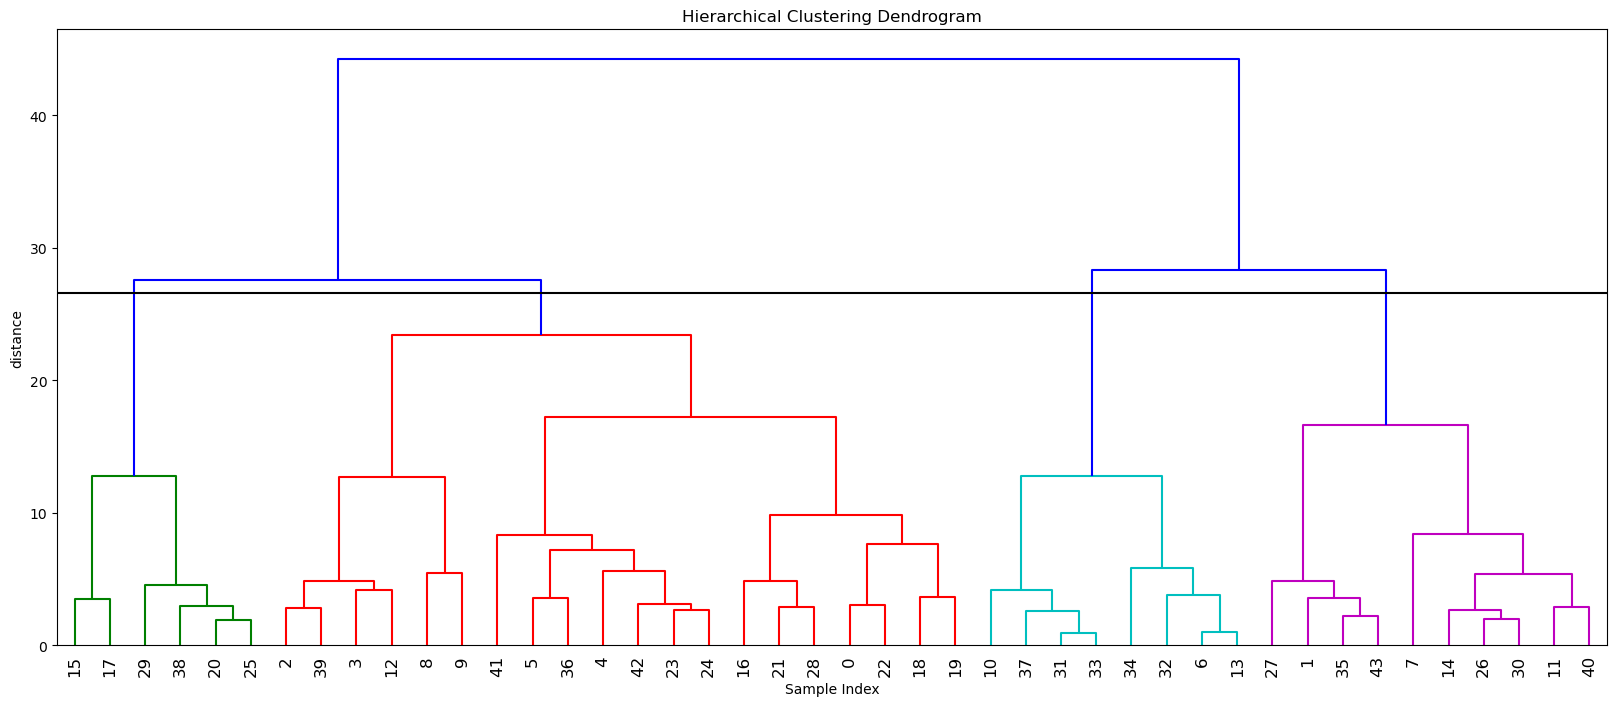

In [174]:
plt.figure(figsize=(20, 8))
fancy_dendrogram(
    pca_linkage,
    #leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=50,  # useful in small plots so annotations don't overlap
    max_d =  0.6*max(pca_linkage.iloc[:,2])
)
plt.show()

In [132]:
cell = df[['Cell', 'Cell_Type']]
cell_dict = dict(zip(cell.Cell, cell.Cell_Type))
cell_dict
control_clusters['Cell_Type'] = control_clusters['name'].map(cell_dict)
control_clusters.to_csv(r"C:\Users\Valerie\Downloads\penk_clusters_updated.csv")

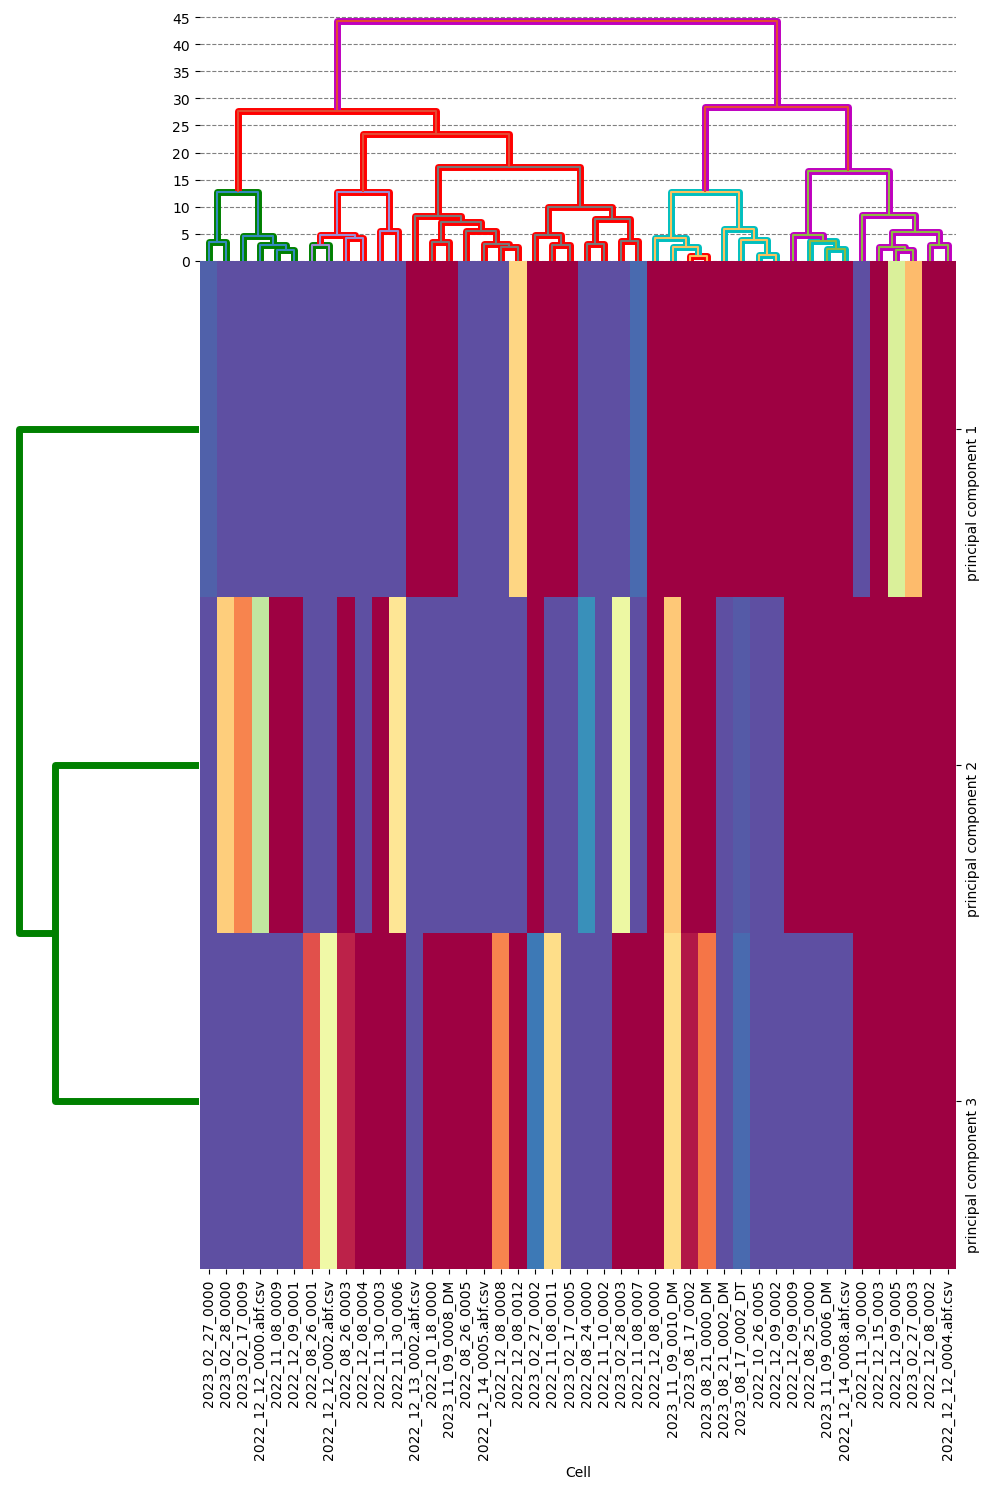

In [133]:
a = sns.clustermap(correlations, row_linkage=row_linkage, col_linkage=col_linkage, method="ward", 
               vmin=-1, vmax=1, figsize=(10, 15), cmap="Spectral_r", center=0, cbar_pos=None,tree_kws=dict(linewidths=5, colors=A['leaves_color_list']), xticklabels=True, yticklabels=True)
den = hierarchy.dendrogram(a.dendrogram_col.linkage, color_threshold=0.5*max(pca_linkage.iloc[:, 2]),ax = a.ax_col_dendrogram) 
a.ax_col_dendrogram.axis('on')
a.ax_col_dendrogram.yaxis.set_major_locator(MaxNLocator())
a.ax_col_dendrogram.yaxis.set_major_formatter(ScalarFormatter())
a.ax_col_dendrogram.grid(axis='y', ls='--', color='grey')
plt.style.use(['ggplot'])
#plt.savefig('control_big.tiff',dpi=300)

In [134]:
control_clusters.set_index(control_clusters.iloc[:,0],drop=True,inplace=True)
control_clusters.sort_index(ascending=True,inplace=True)
#control_clusters.to_csv("C:/Users/Valerie/Downloads/penk_clusters.csv")

In [135]:
matplotlib.style.use('default')
from cycler import cycler
matplotlib.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

Text(0, 0.5, 'PC2')

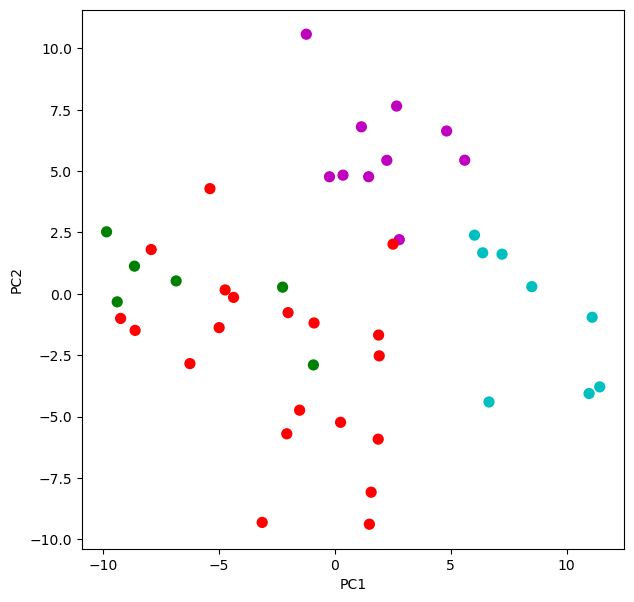

In [136]:
plt.figure(figsize=(7,7))
plt.scatter(principalDf['principal component 1'],principalDf['principal component 2'],c=control_clusters.iloc[:,2], cmap='hsv', s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.xlim(-5,10)
#plt.ylim(-5,10)